In [1]:
#Downloading and formatting the dataset

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers = symbols_list, start = start_date, end = end_date)
df = df.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed


In [2]:
df['adj close'] = df['close'].copy()

In [3]:
#Computing the technical indicators

df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))

df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1]) 
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20)
    if macd is not None:
        return macd.iloc[:, 0].sub(macd.iloc[:, 0].mean()).div(macd.iloc[:, 0].std())
    else:
        return pd.Series([np.nan] * len(close), index=close.index)

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

In [4]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-04-06 A        50.028305   50.103604   49.190575   49.604735   1548200.0   
           AAPL     33.368809   33.568566   33.320029   33.515140  84596000.0   
           ABBV     46.189194   46.267264   45.884010   46.153705   4628400.0   
           ABT      37.831062   37.952346   37.553848   37.952346   6067300.0   
           ACGL     29.915266   30.076919   29.801159   30.023036   1017000.0   
...                       ...         ...         ...         ...         ...   
2025-04-03 XYL     110.989998  116.279999  110.879997  115.459999   2755600.0   
           YUM     161.449997  161.809998  157.889999  158.190002   2615300.0   
           ZBH     112.660004  114.440002  111.410004  111.830002   2920600.0   
           ZBRA    238.500000  270.540009  238.100006  270.489990   1372200.0   
           ZTS     159.610001  166.339996  159.259995  163.610001   3275500.0   

Price               adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-04-06 A        50.028305          0.000141        NaN       NaN   
           AAPL     33.368809          0.000020        NaN       NaN   
           ABBV     46.189194          0.000034        NaN       NaN   
           ABT      37.831062          0.000052        NaN       NaN   
           ACGL     29.915266          0.000037        NaN       NaN   
...                       ...               ...        ...       ...   
2025-04-03 XYL     110.989998          0.000528  31.141251  4.745960   
           YUM     161.449997          0.000140  64.573009  5.038278   
           ZBH     112.660004          0.000339  58.786576  4.671745   
           ZBRA    238.500000          0.002038  25.829543  5.560313   
           ZTS     159.610001          0.000709  43.325844  5.069344   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-04-06 A            NaN       NaN       NaN       NaN      77.453822  
           AAPL         NaN       NaN       NaN       NaN    2822.867745  
           ABBV         NaN       NaN       NaN       NaN     213.782064  
           ABT          NaN       NaN       NaN       NaN     229.532404  
           ACGL         NaN       NaN       NaN       NaN      30.423826  
...                     ...       ...       ...       ...            ...  
2025-04-03 XYL     4.807874  4.869788  1.374980 -1.559676     305.844038  
           YUM     5.064544  5.090811  1.435051  1.342642     422.240177  
           ZBH     4.714359  4.756974 -0.296094  0.757188     329.034807  
           ZBRA    5.646153  5.731993  0.880315 -1.666726     327.269700  
           ZTS     5.104032  5.138720  0.605539 -0.598244     522.802557  

[990745 rows x 14 columns]

In [5]:
#Aggregate to monthly level and filter top 150 most liquid stocks for each month
'''This is done to reduce training time for the ML model and experiment with strats'''
#This computes the average monthly dollar volume to give a sense of liquidity

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                          'open','high','low','close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack().to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

In [6]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-05-31 A          125.325439   56.795994          0.000171  69.846024   
           AAPL      4202.702522   35.628983          0.000044  57.014890   
           ABBV       267.822619   47.322498          0.000069  62.777905   
           ABT        232.370871   39.796944          0.000039  69.828528   
           ACGL        28.368989   30.824963          0.000222  50.680471   
...                          ...         ...               ...        ...   
2025-04-30 XYL        263.580762  110.989998          0.000528  31.141251   
           YUM        307.735435  161.449997          0.000140  64.573009   
           ZBH        205.010186  112.660004          0.000339  58.786576   
           ZBRA       173.580114  238.500000          0.002038  25.829543   
           ZTS        432.357872  159.610001          0.000709  43.325844   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-05-31 A       3.953567  4.005900  4.058233 -1.422108  0.599096  
           AAPL    3.564542  3.599417  3.634293 -1.437009 -0.012881  
           ABBV    3.863636  3.879356  3.895076 -1.757995 -0.173556  
           ABT     3.644491  3.674411  3.704331 -1.693753 -0.047361  
           ACGL    3.425951  3.443274  3.460596 -1.245654 -0.210359  
...                     ...       ...       ...       ...       ...  
2025-04-30 XYL     4.745960  4.807874  4.869788  1.374980 -1.559676  
           YUM     5.038278  5.064544  5.090811  1.435051  1.342642  
           ZBH     4.671745  4.714359  4.756974 -0.296094  0.757188  
           ZBRA    5.560313  5.646153  5.731993  0.880315 -1.666726  
           ZTS     5.069344  5.104032  5.138720  0.605539 -0.598244  

[47322 rows x 9 columns]

In [7]:
#Calculating the 5 year rolling average rolling average for each stock
#and use this value to filter out top 150 most liquid stocks for each month

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending = False)

#We are finding the 150 most liquid stocks then dropping the columns that we dont need
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1)

In [8]:
'''Removing the timezones from the dataframe data as they are not necessary'''
#Remove the time zone from the 'date' index of data
data.index = data.index.set_levels([data.index.levels[0].tz_localize(None), data.index.levels[1]])

#Convert the 'date' index to only the date part (remove time part)
data.index = data.index.set_levels([data.index.levels[0].date, data.index.levels[1]])

In [9]:
#Calculating monthly returns for different time horizons as features
'''To capture time series dynamics that reflect, for instance, momentum patterns, we
compute historical returns using the method .pct_change(lag), that is, returns over
various monthly periods as identified by lags'''

def calculate_returns(df):

    outlier_cutoff = 0.005 #only the 99.005 percentile is considered and values above this percentile are assigned the same value as the cutoff
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                    upper = x.quantile(1 - outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df
    
data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()

In [10]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-04-30 AAPL     48.069221          0.000173  60.713649  3.857410   
           ABBV     61.615765          0.000218  48.304532  4.110328   
           ABT      71.977150          0.000146  58.185346  4.217225   
           ACN     169.004074          0.000028  75.230515  5.088947   
           ADBE    289.250000          0.000077  71.264339  5.573869   
...                       ...               ...        ...       ...   
2025-04-30 VZ       45.619999          0.000232  61.460610  3.771488   
           WDAY    228.330002          0.000380  36.150296  5.441271   
           WFC      65.669998          0.000832  35.203583  4.209484   
           WMT      87.260002          0.000786  44.393853  4.432272   
           XOM     112.430000          0.000287  48.778644  4.687552   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-04-30 AAPL    3.894572  3.931734 -1.223093  0.165605   0.056436   
           ABBV    4.148598  4.186869 -1.015281 -0.343852  -0.001829   
           ABT     4.263620  4.310016 -0.592183 -0.188736  -0.000680   
           ACN     5.112715  5.136482 -1.279075  0.550132   0.046375   
           ADBE    5.615850  5.657831 -1.136821  0.441367   0.085407   
...                     ...       ...       ...       ...        ...   
2025-04-30 VZ      3.814869  3.858249  1.417687  1.438201   0.005732   
           WDAY    5.501764  5.562257  0.704588 -1.365255  -0.022267   
           WFC     4.275494  4.341504  3.947029 -1.323407  -0.085249   
           WMT     4.472975  4.513678  4.098570 -2.580676  -0.006037   
           XOM     4.748479  4.809406  1.253609  1.368278  -0.054654   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-04-30 AAPL     0.076540   0.065846  -0.013082   0.007179    0.017591  
           ABBV     0.007560   0.000633   0.007520  -0.012577   -0.012383  
           ABT      0.014489   0.030595   0.025654   0.023228    0.027978  
           ACN      0.068316   0.062511   0.026297   0.017264    0.017351  
           ADBE     0.049717   0.052880   0.027528   0.018767    0.022450  
...                      ...        ...        ...        ...         ...  
2025-04-30 VZ       0.028819   0.050162   0.016324   0.016988    0.016263  
           WDAY    -0.068843  -0.044888  -0.003973   0.000591   -0.005764  
           WFC     -0.084313  -0.057402   0.003700   0.013382    0.010531  
           WMT     -0.058018  -0.037596   0.011354   0.027918    0.033611  
           XOM      0.004928   0.020200  -0.003473  -0.003132   -0.001452  

[10483 rows x 14 columns]

In [11]:
'''Download FAMA-FRENCH factors and calculate rolling factor betas'''
#we are introducing the FAMA french data to estimate the exposure of assets to
#common risk factors with linear regression.
#five factors are market risk size, value, operating probability and investment
#these have been shown to empirically assess asset returns
#we can access historical returns using pandas-datareader and estimate historial 
#exposures using Rollingols model

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010')[0].drop('RF', axis = 1)

factor_data.index = factor_data.index.to_timestamp() #but this returns beginning of month data, which we have to fix to end of month

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'
#now we just combine this with the 1 month return from previous code

# '''We are adding timezones to factordata date as data has timezones'''
# #Check if 'factor_data' is timezone-aware
# if factor_data.index.tz is None:
#     # If it's not timezone-aware, localize it to UTC (or any timezone you prefer)
#     factor_data.index = factor_data.index.tz_localize('UTC')
# else:
#     # If it's already timezone-aware, ensure it's in the same timezone (UTC)
#     factor_data.index = factor_data.index.tz_convert('UTC')
# '''end of bug fix'''

factor_data = factor_data.join(data['return_1m']).sort_index()

In [12]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-04-30 AAPL    0.0397 -0.0115  0.0216  0.0159 -0.0222   0.056436
           ABBV    0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.001829
           ABT     0.0397 -0.0115  0.0216  0.0159 -0.0222  -0.000680
           ACN     0.0397 -0.0115  0.0216  0.0159 -0.0222   0.046375
           ADBE    0.0397 -0.0115  0.0216  0.0159 -0.0222   0.085407
...                   ...     ...     ...     ...     ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.096744
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.032161
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.077852
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.021079
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.088081

[9920 rows x 6 columns]

In [13]:
'''Filter out stocks with less than 10 months of data'''
#we do this because we are going to use rolling window for the regression of 24mnths
#stocks without enough data can break our functions

observations = factor_data.groupby(level = 1).size()
valid_stocks = observations[observations >= 10] #more than 10 months data

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [14]:
'''Calculating the rolling factor betas'''

betas = (factor_data.groupby(level = 1,
                    group_keys = False)
        .apply(lambda x: RollingOLS(endog = x['return_1m'],
                                    exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                    window = min(24, x.shape[0]), #if less than 24 months data, still calculate ols
                                    min_nobs = len(x.columns)+1)
        .fit(params_only = True)
        .params
        .drop('const', axis = 1)))

In [15]:
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-04-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-12-31 VZ      1.221471 -0.867782  0.802731  0.672702 -0.497234
           WDAY    0.979394 -1.334232  0.613028 -2.276787 -1.606166
           WFC     0.426386  0.043776  0.866022 -2.252680 -0.077334
           WMT     0.740233  0.331349 -0.559873  1.171455  0.734967
           XOM     0.693089  0.041712  0.255468  1.165575  0.737648

[9883 rows x 5 columns]

In [16]:
'''Joining the betas to the features as well'''
#however we cannot blindly join betas to our dataset
#this is because we use the factor at the beginning of the month and return at the end of the month to compute betas.
#so at the end of the month, well be able to run the regression and have the betas but we will have them in the next month.
#so the betas of oct 31 will be known in nov 1
#so we shift the betas one month ahead before joining
#doing betas.shift() will simply shift betas forward by ticker, so XOM will get WMT's beta

data = data.join( betas.groupby('ticker').shift() )

#removing the NaN values in the FAMA-French columns
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis = 1)

In [17]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-04-30 AAPL            0.000173  60.713649  3.857410  3.894572  3.931734   
           ABBV            0.000218  48.304532  4.110328  4.148598  4.186869   
           ABT             0.000146  58.185346  4.217225  4.263620  4.310016   
           ACN             0.000028  75.230515  5.088947  5.112715  5.136482   
           ADBE            0.000077  71.264339  5.573869  5.615850  5.657831   
...                             ...        ...       ...       ...       ...   
2025-04-30 VZ              0.000232  61.460610  3.771488  3.814869  3.858249   
           WDAY            0.000380  36.150296  5.441271  5.501764  5.562257   
           WFC             0.000832  35.203583  4.209484  4.275494  4.341504   
           WMT             0.000786  44.393853  4.432272  4.472975  4.513678   
           XOM             0.000287  48.778644  4.687552  4.748479  4.809406   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-04-30 AAPL   -1.223093  0.165605   0.056436   0.076540   0.065846   
           ABBV   -1.015281 -0.343852  -0.001829   0.007560   0.000633   
           ABT    -0.592183 -0.188736  -0.000680   0.014489   0.030595   
           ACN    -1.279075  0.550132   0.046375   0.068316   0.062511   
           ADBE   -1.136821  0.441367   0.085407   0.049717   0.052880   
...                     ...       ...        ...        ...        ...   
2025-04-30 VZ      1.417687  1.438201   0.005732   0.028819   0.050162   
           WDAY    0.704588 -1.365255  -0.022267  -0.068843  -0.044888   
           WFC     3.947029 -1.323407  -0.085249  -0.084313  -0.057402   
           WMT     4.098570 -2.580676  -0.006037  -0.058018  -0.037596   
           XOM     1.253609  1.368278  -0.054654   0.004928   0.020200   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-04-30 AAPL    -0.013082   0.007179    0.017591  1.268625 -0.166472   
           ABBV     0.007520  -0.012577   -0.012383  0.555309  0.204673   
           ABT      0.025654   0.023228    0.027978  0.765280 -0.020820   
           ACN      0.026297   0.017264    0.017351  1.195176 -0.209653   
           ADBE     0.027528   0.018767    0.022450  1.343535 -0.607892   
...                      ...        ...         ...       ...       ...   
2025-04-30 VZ       0.016324   0.016988    0.016263  0.476211 -0.498232   
           WDAY    -0.003973   0.000591   -0.005764  1.182270 -0.599418   
           WFC      0.003700   0.013382    0.010531  1.112509 -0.129051   
           WMT      0.011354   0.027918    0.033611  0.654601 -0.328039   
           XOM     -0.003473  -0.003132   -0.001452  0.972349 -0.021549   

                        HML       RMW       CMA  
date       ticker                                
2019-04-30 AAPL   -0.651275  0.306504  0.406700  
           ABBV   -0.122560  0.346666  0.536691  
           ABT    -0.429969  0.131474  1.019060  
           ACN    -0.211395  0.350115 -0.024679  
           ADBE   -0.238993  0.305404 -0.405353  
...                     ...       ...       ...  
2025-04-30 VZ      0.339266  0.124704  0.047094  
           WDAY   -0.358726 -0.855044 -0.391390  
           WFC     1.629066 -0.664904 -1.088708  
           WMT    -0.342433  0.197624  0.563574  
           XOM     0.952387 -0.449762  0.322121  

[10271 rows x 18 columns]

In [18]:
'''Now we will start with the ML model as the data is complete'''
#We have the top 150 most liquid stocks at the end of each month.
#Our job is to build portfolios at the EOM and evaluate which stocks to put in.

'''We'll use a K-means clustering alg to group similar assets based on their features'''
#Split the stocks into four diff groups (optimal number of clusters as said by a quant)

"We'll use a K-means clustering alg to group similar assets based on their features"

In [19]:
from sklearn.cluster import KMeans

#Now we'll assign a cluster to each stock
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, #4 clusters: 0,1,2,3
                           random_state = 0,  #clustering works with random seed
                           init = 'random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [13]:
'''Visualizing the clustering'''
#Since we didnt normalize the RSI before, we can use this for visualization
#We cannot visualize all the features in even a 3 dimensional space

def plot_clusters(data):

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    #5th index (6th column) is the ATR in the dataframe
    #1st index (2nd column) is the RSI in the dataframe
    #Plotting ATR against RSI
    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color = 'red', label = 'cluster_0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color = 'green', label = 'cluster_1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color = 'blue', label = 'cluster_2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color = 'black', label = 'cluster_3')

    plt.legend()
    plt.show()

In [ ]:
#actually plotting

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

#an observation i made was that the clusters are grouped based on RSI values
#clusters more or less are grouped as >60, 50-60, 40-50 and <40
#however since K-means centroids are random, the clusters are also a bit random

In [20]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18)) #checked the k means docs for this. 18 represents the number of columns of data

initial_centroids[:, 1] = target_rsi_values #rsi value column

In [21]:
'''Now we are going to apply the newfound knowledge about initial centroids to the K-means clustering alg'''
#We will drop the original clusters

data = data.drop('cluster', axis = 1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, #4 clusters: 0,1,2,3
                           random_state = 0,  #clustering works with initial centroids
                           init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [22]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-04-30 AAPL            0.000173  60.713649  3.857410  3.894572  3.931734   
           ABBV            0.000218  48.304532  4.110328  4.148598  4.186869   
           ABT             0.000146  58.185346  4.217225  4.263620  4.310016   
           ACN             0.000028  75.230515  5.088947  5.112715  5.136482   
           ADBE            0.000077  71.264339  5.573869  5.615850  5.657831   
...                             ...        ...       ...       ...       ...   
2025-04-30 VZ              0.000232  61.460610  3.771488  3.814869  3.858249   
           WDAY            0.000380  36.150296  5.441271  5.501764  5.562257   
           WFC             0.000832  35.203583  4.209484  4.275494  4.341504   
           WMT             0.000786  44.393853  4.432272  4.472975  4.513678   
           XOM             0.000287  48.778644  4.687552  4.748479  4.809406   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-04-30 AAPL   -1.223093  0.165605   0.056436   0.076540   0.065846   
           ABBV   -1.015281 -0.343852  -0.001829   0.007560   0.000633   
           ABT    -0.592183 -0.188736  -0.000680   0.014489   0.030595   
           ACN    -1.279075  0.550132   0.046375   0.068316   0.062511   
           ADBE   -1.136821  0.441367   0.085407   0.049717   0.052880   
...                     ...       ...        ...        ...        ...   
2025-04-30 VZ      1.417687  1.438201   0.005732   0.028819   0.050162   
           WDAY    0.704588 -1.365255  -0.022267  -0.068843  -0.044888   
           WFC     3.947029 -1.323407  -0.085249  -0.084313  -0.057402   
           WMT     4.098570 -2.580676  -0.006037  -0.058018  -0.037596   
           XOM     1.253609  1.368278  -0.054654   0.004928   0.020200   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-04-30 AAPL    -0.013082   0.007179    0.017591  1.268625 -0.166472   
           ABBV     0.007520  -0.012577   -0.012383  0.555309  0.204673   
           ABT      0.025654   0.023228    0.027978  0.765280 -0.020820   
           ACN      0.026297   0.017264    0.017351  1.195176 -0.209653   
           ADBE     0.027528   0.018767    0.022450  1.343535 -0.607892   
...                      ...        ...         ...       ...       ...   
2025-04-30 VZ       0.016324   0.016988    0.016263  0.476211 -0.498232   
           WDAY    -0.003973   0.000591   -0.005764  1.182270 -0.599418   
           WFC      0.003700   0.013382    0.010531  1.112509 -0.129051   
           WMT      0.011354   0.027918    0.033611  0.654601 -0.328039   
           XOM     -0.003473  -0.003132   -0.001452  0.972349 -0.021549   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-04-30 AAPL   -0.651275  0.306504  0.406700        2  
           ABBV   -0.122560  0.346666  0.536691        1  
           ABT    -0.429969  0.131474  1.019060        2  
           ACN    -0.211395  0.350115 -0.024679        3  
           ADBE   -0.238993  0.305404 -0.405353        3  
...                     ...       ...       ...      ...  
2025-04-30 VZ      0.339266  0.124704  0.047094        3  
           WDAY   -0.358726 -0.855044 -0.391390        0  
           WFC     1.629066 -0.664904 -1.088708        0  
           WMT    -0.342433  0.197624  0.563574        1  
           XOM     0.952387 -0.449762  0.322121        1  

[10271 rows x 19 columns]

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [23]:
'''At the beginnng of each new month, select stocks based on cluster and form'''
'''a portfolio based on efficient frointier max sharpe ratio optimization'''
#momentum is persistent, and our idea would be that stocks clustered around 70 rsi centroid should
#continue to outperform in the following month, So we would select the stocks of cluster 3

filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level = 1)
filtered_df.index = filtered_df.index + pd.DateOffset(1) #moving each day with one so we go from end of month to beginning of next month
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()

In [24]:
filtered_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-05-01 ACN             0.000028  75.230515  5.088947  5.112715  5.136482   
           ADBE            0.000077  71.264339  5.573869  5.615850  5.657831   
           ADSK            0.000119  69.510891  5.099089  5.148353  5.197618   
           ALGN            0.000121  69.905989  5.608861  5.688334  5.767807   
           AMZN            0.000111  67.074669  4.504914  4.547736  4.590558   
...                             ...        ...       ...       ...       ...   
2025-05-01 MDLZ            0.000342  62.029858  4.150764  4.199418  4.248071   
           PM              0.000349  69.135402  4.995578  5.038807  5.082036   
           T               0.000202  67.402944  3.281043  3.340109  3.399174   
           UNH             0.000488  63.514155  6.163211  6.229296  6.295381   
           VZ              0.000232  61.460610  3.771488  3.814869  3.858249   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-05-01 ACN    -1.279075  0.550132   0.046375   0.068316   0.062511   
           ADBE   -1.136821  0.441367   0.085407   0.049717   0.052880   
           ADSK   -1.093343  0.850526   0.143691   0.045584   0.065798   
           ALGN   -0.172162  0.930664   0.141913   0.119703   0.092566   
           AMZN   -1.228618  0.615237   0.081859   0.083895   0.038776   
...                     ...       ...        ...        ...        ...   
2025-05-01 MDLZ    1.772354  1.521712   0.000737   0.031759   0.056446   
           PM      3.237098  2.050930   0.021042   0.026129   0.078871   
           T       2.597412  2.395183   0.011315   0.021477   0.064199   
           UNH     1.159472  1.326822   0.031866   0.068984   0.000160   
           VZ      1.417687  1.438201   0.005732   0.028819   0.050162   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-05-01 ACN      0.026297   0.017264    0.017351  1.195176 -0.209653   
           ADBE     0.027528   0.018767    0.022450  1.343535 -0.607892   
           ADSK     0.054995   0.037059    0.029380  1.427026 -0.193643   
           ALGN     0.066052  -0.010381    0.022072  0.795896  1.638686   
           AMZN     0.031650   0.008989    0.017409  1.226373 -0.503462   
...                      ...        ...         ...       ...       ...   
2025-05-01 MDLZ     0.001064   0.001628   -0.002510  0.650544 -0.202190   
           PM       0.037307   0.042280    0.049407  0.651890 -0.099367   
           T        0.042673   0.047920    0.047489  0.598777 -0.133833   
           UNH     -0.005893  -0.005802    0.010621  0.542113 -0.100176   
           VZ       0.016324   0.016988    0.016263  0.476211 -0.498232   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-05-01 ACN    -0.211395  0.350115 -0.024679        3  
           ADBE   -0.238993  0.305404 -0.405353        3  
           ADSK    0.444053 -0.398768 -0.905018        3  
           ALGN   -0.196058  0.804681 -1.571954        3  
           AMZN   -0.326753 -0.587029 -0.608195        3  
...                     ...       ...       ...      ...  
2025-05-01 MDLZ   -0.205266  0.502452  0.912467        3  
           PM      0.289412  0.193818  0.495319        3  
           T       0.400913  0.324185  0.422774        3  
           UNH     0.055417  0.497656  0.085958        3  
           VZ      0.339266  0.124704  0.047094        3  

[1958 rows x 19 columns]

In [25]:
'''DEFINE PORTFOLIO OPTIMIZATION FUNCTION'''
#we will use the PyPortfolioOpt package and EfficientFrontier to maximize the sharpe ratio
#to optimize the weights of a given portfolio, we would need to supply last one year prices to the function
#apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio)

'DEFINE PORTFOLIO OPTIMIZATION FUNCTION'

In [36]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#the lower bound is here because if i just put in 0, the porfolio might be designed such that:
#1 stock has a weight of 1 and the others have a weight of 0

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices = prices,
                                                      frequency = 252) #1 yr of trading data
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    
    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound, .1),
                           solver = 'SCS')
    weights = ef.max_sharpe()

    return ef.clean_weights()

In [27]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                     start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1]) #past year of data collected

[*********************100%***********************]  154 of 154 completed


In [28]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-04-30 AAPL            0.000173  60.713649  3.857410  3.894572  3.931734   
           ABBV            0.000218  48.304532  4.110328  4.148598  4.186869   
           ABT             0.000146  58.185346  4.217225  4.263620  4.310016   
           ACN             0.000028  75.230515  5.088947  5.112715  5.136482   
           ADBE            0.000077  71.264339  5.573869  5.615850  5.657831   
...                             ...        ...       ...       ...       ...   
2025-04-30 VZ              0.000232  61.460610  3.771488  3.814869  3.858249   
           WDAY            0.000380  36.150296  5.441271  5.501764  5.562257   
           WFC             0.000832  35.203583  4.209484  4.275494  4.341504   
           WMT             0.000786  44.393853  4.432272  4.472975  4.513678   
           XOM             0.000287  48.778644  4.687552  4.748479  4.809406   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-04-30 AAPL   -1.223093  0.165605   0.056436   0.076540   0.065846   
           ABBV   -1.015281 -0.343852  -0.001829   0.007560   0.000633   
           ABT    -0.592183 -0.188736  -0.000680   0.014489   0.030595   
           ACN    -1.279075  0.550132   0.046375   0.068316   0.062511   
           ADBE   -1.136821  0.441367   0.085407   0.049717   0.052880   
...                     ...       ...        ...        ...        ...   
2025-04-30 VZ      1.417687  1.438201   0.005732   0.028819   0.050162   
           WDAY    0.704588 -1.365255  -0.022267  -0.068843  -0.044888   
           WFC     3.947029 -1.323407  -0.085249  -0.084313  -0.057402   
           WMT     4.098570 -2.580676  -0.006037  -0.058018  -0.037596   
           XOM     1.253609  1.368278  -0.054654   0.004928   0.020200   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-04-30 AAPL    -0.013082   0.007179    0.017591  1.268625 -0.166472   
           ABBV     0.007520  -0.012577   -0.012383  0.555309  0.204673   
           ABT      0.025654   0.023228    0.027978  0.765280 -0.020820   
           ACN      0.026297   0.017264    0.017351  1.195176 -0.209653   
           ADBE     0.027528   0.018767    0.022450  1.343535 -0.607892   
...                      ...        ...         ...       ...       ...   
2025-04-30 VZ       0.016324   0.016988    0.016263  0.476211 -0.498232   
           WDAY    -0.003973   0.000591   -0.005764  1.182270 -0.599418   
           WFC      0.003700   0.013382    0.010531  1.112509 -0.129051   
           WMT      0.011354   0.027918    0.033611  0.654601 -0.328039   
           XOM     -0.003473  -0.003132   -0.001452  0.972349 -0.021549   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-04-30 AAPL   -0.651275  0.306504  0.406700        2  
           ABBV   -0.122560  0.346666  0.536691        1  
           ABT    -0.429969  0.131474  1.019060        2  
           ACN    -0.211395  0.350115 -0.024679        3  
           ADBE   -0.238993  0.305404 -0.405353        3  
...                     ...       ...       ...      ...  
2025-04-30 VZ      0.339266  0.124704  0.047094        3  
           WDAY   -0.358726 -0.855044 -0.391390        0  
           WFC     1.629066 -0.664904 -1.088708        0  
           WMT    -0.342433  0.197624  0.563574        1  
           XOM     0.952387 -0.449762  0.322121        1  

[10271 rows x 19 columns]

In [29]:
new_df.rename(columns = {'Close':'Adj Close'}, inplace = True)
new_df

Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-04-30   38.993229   71.553276         NaN   51.687729  137.482681   
2018-05-01   39.899273   75.644142         NaN   52.301262  138.137390   
2018-05-02   41.661839   74.384277         NaN   51.438778  137.037155   
2018-05-03   41.737335   74.317589         NaN   51.509899  137.964630   
2018-05-04   43.374828   74.236053         NaN   52.230145  139.519440   
...                ...         ...         ...         ...         ...   
2025-03-31  222.130005  209.520004  119.459999  132.649994  312.040009   
2025-04-01  223.190002  206.270004  121.180000  131.690002  313.579987   
2025-04-02  223.889999  205.190002  122.800003  131.929993  316.329987   
2025-04-03  203.190002  201.639999  113.970001  131.630005  301.459991   
2025-04-04  195.279999  197.147095  108.715698  129.160004  296.869995   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-04-30  221.600006   76.625893  101.935013  125.900002  249.850006  ...   
2018-05-01  224.080002   77.950493  102.556587  127.059998  251.339996  ...   
2018-05-02  221.100006   77.459244  105.370834  125.260002  249.470001  ...   
2018-05-03  226.050003   77.117134  106.268654  127.599998  255.139999  ...   
2018-05-04  228.509995   79.187386  108.219635  129.460007  258.970001  ...   
...                ...         ...         ...         ...         ...  ...   
2025-03-31  383.529999  201.669998  305.529999  261.799988  158.860001  ...   
2025-04-01  383.200012  199.179993  306.540009  264.609985  158.080002  ...   
2025-04-02  385.779999  199.589996  307.230011  267.929993  163.979996  ...   
2025-04-03  367.250000  180.880005  305.390015  257.149994  154.240005  ...   
2025-04-04  358.440002  170.309998  299.649994  249.029999  150.130005  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ       WBA     WDAY       WDC       WFC   
Date                                                                            
2018-04-30  5667700  1717300  28938900   4399100  1126800  10008892  17050500   
2018-05-01  3680800  1648600  16101400   5056700   880500   5987501  13903800   
2018-05-02  5677400  2565200  18515900   5411300  1227900   7173174  16397200   
2018-05-03  3576400  1518900  16114100   6938900  1557700   5989750  19216100   
2018-05-04  2923000  2263800  10669300   5523700  2020100   6321426  16660500   
...             ...      ...       ...       ...      ...       ...       ...   
2025-03-31  2766700  2231900  27786900  10050200  3312700   8212200  14855300   
2025-04-01  2366400  1249500  15710800  10689000  2567400   5292700  10661000   
2025-04-02  2411500   988400  21924100   9254500  1926200   5017500   8854100   
2025-04-03  9512700  2063800  30457800  22720000  5081600  21302700  25855000   
2025-04-04  2281968   911710  11874512   9167229  1264504   7733811   9487020   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2018-04-30  26057700  2299100  15028800  
2018-05-01  20873100  2864400  16231000  
2018-05-02  18249000  1816000  13883700  
2018-05-03  20628300  1781300  12243100  
2018-05-04  20914500  2311900   9887200  
...              ...      ...       ...  
2025-03-31  30269300  2115000  21652300  
2025-04-01  22080300  1499700  12425400  
2025-04-02  19384100  2539900  12614600  
2025-04-03  32988300  5506600  21189400  
2025-04-04  10436659  2987333  10287587  

[1744 rows x 770 columns]

In [30]:
#Calculate daily returns for each stock whcih could land up in the portfolio
#Loop over each month start, select stocks for the month and calculate weights for the nextmonth
#if max sharpe ratio optimization fails for a monnth, apply equally weighted weights
#calculate each day portfolio return

In [31]:
retruns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date] #stocks for each month which will form the portfolio

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    #weights = optimize_weights(prices = optimization_df,
    #                       lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

In [32]:
optimization_start_date = (pd.to_datetime( min(fixed_dates.keys()) ) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
optimization_end_date = (pd.to_datetime( max(fixed_dates.keys()) ) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

In [34]:
#now creating an optimization dataframe to calculate the weights of the stocks in the portfolio

optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][fixed_dates[dates[-1].strftime('%Y-%m-%d')]] #latest date (1 day more than optimization end date) that is in the dict fixed_dates

In [37]:
weights = optimize_weights(prices = optimization_df,
                           lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

weights = pd.DataFrame(weights, index = pd.Series(0))

In [38]:
#implementing the weights back into the original loop:

retruns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date] #stocks for each month which will form the portfolio

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]
        success = False

        try:
            weights = optimize_weights(prices = optimization_df,
                                lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

            weights = pd.DataFrame(weights, index = pd.Series(0))

            success = True
        except:
            print(f"Max sharpe optimization failed for {start_date}, Continuing with equal weights")

        #if the max sharpe optimization fails, we just use an equally weighted portfolio
        if not success:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                index=optimization_df.columns.tolist(),
                                columns=pd.Series(0)).T

        temp_df = retruns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
                        .merge( weights.stack().to_frame('weight').reset_index(level = 0, drop = True),
                        left_index = True,
                        right_index = True )\
                        .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level = 0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

Max sharpe optimization failed for 2019-05-01, Continuing with equal weights
Max sharpe optimization failed for 2019-06-01, Continuing with equal weights
Max sharpe optimization failed for 2019-07-01, Continuing with equal weights
Max sharpe optimization failed for 2019-12-01, Continuing with equal weights
Max sharpe optimization failed for 2020-01-01, Continuing with equal weights
Max sharpe optimization failed for 2020-03-01, Continuing with equal weights
Max sharpe optimization failed for 2020-04-01, Continuing with equal weights
Max sharpe optimization failed for 2020-06-01, Continuing with equal weights
Max sharpe optimization failed for 2020-07-01, Continuing with equal weights
Max sharpe optimization failed for 2020-09-01, Continuing with equal weights
Max sharpe optimization failed for 2020-11-01, Continuing with equal weights
Max sharpe optimization failed for 2020-12-01, Continuing with equal weights
Max sharpe optimization failed for 2021-02-01, Continuing with equal weights

<Axes: xlabel='date'>

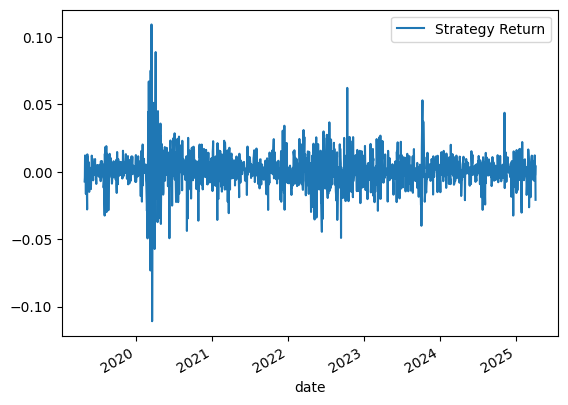

In [39]:
portfolio_df.plot()

In [41]:
'''Visualize portfolio returns and compare to beta/S&P500 returns'''
#first we download the SPY ETF data, then build an object that calculates the log retuns of the SPY

end_date = dt.datetime.now()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

spy = yf.download(tickers = 'SPY',
                  start = start_date,
                  end = end_date)

spy.rename(columns = {'Close':'Adj Close'}, inplace = True)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold', 'Date': 'date'}, axis = 1)
spy_ret.columns = ['SPY Buy&Hold'] #to make consistent with the portfolio_df

[*********************100%***********************]  1 of 1 completed


In [42]:
#Now, we merge the portfolio returns into the spy returns

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

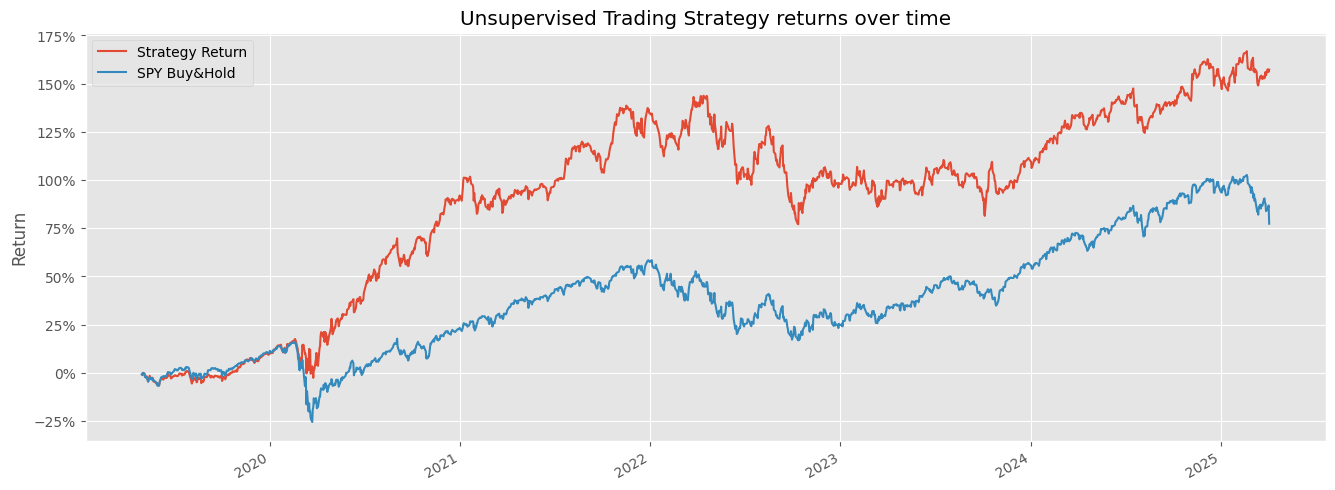

In [44]:
#comparing our alpha to our beta
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumilative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumilative_return.plot(figsize=(16,6))

plt.title('Unsupervised Trading Strategy returns over time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')

plt.show()

In [29]:
'''FINAL CONCLUSIONS'''
# 1) Selected the top 150 most liquid stocks with their dollar volume
# 2) Calculated 18 different features for each stock
# 3) Applied a K-Means clustering algorithm to assign clusters for every stock
# 4) Supplied our custom centroid with a custom array
# 5) Optimized the portfolio for each month to have the max sharpe portfolio weight

'FINAL CONCLUSIONS'